In [1]:
# CELL 1: KAGGLE SETUP

from google.colab import files
import os, shutil

# 1) Upload kaggle.json from your computer (download it from Kaggle -> Account -> Create New API Token)
print("Upload kaggle.json (from your computer)...")
uploaded = files.upload()

if "kaggle.json" not in uploaded:
    raise RuntimeError("You must upload kaggle.json")

# 2) Move it to the right place
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# 3) Fix permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# 4) Install Kaggle CLI
!pip install -q kaggle
!kaggle --version


Upload kaggle.json (from your computer)...


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


In [2]:
# CELL 2: DOWNLOAD HAM10000 FROM KAGGLE

DATA_ROOT = "/content/ham10000"
os.makedirs(DATA_ROOT, exist_ok=True)

# Download the dataset zip into /content/ham10000
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p "$DATA_ROOT"

# List downloaded files
!ls -lh "$DATA_ROOT"


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:30<00:00, 79.7MB/s]
100% 5.20G/5.20G [01:30<00:00, 62.0MB/s]
total 5.2G
-rw-r--r-- 1 root root 5.2G Oct  6  2019 skin-cancer-mnist-ham10000.zip


In [3]:
# CELL 3: UNZIP HAM10000 DATASET

ZIP_PATH = "/content/ham10000/skin-cancer-mnist-ham10000.zip"

!unzip -q "$ZIP_PATH" -d "/content/ham10000"

print("Contents of /content/ham10000:")
!ls -R /content/ham10000


Streaming output truncated to the last 5000 lines.
ISIC_0024320.jpg  ISIC_0025570.jpg  ISIC_0026820.jpg  ISIC_0028070.jpg
ISIC_0024321.jpg  ISIC_0025571.jpg  ISIC_0026821.jpg  ISIC_0028071.jpg
ISIC_0024322.jpg  ISIC_0025572.jpg  ISIC_0026822.jpg  ISIC_0028072.jpg
ISIC_0024323.jpg  ISIC_0025573.jpg  ISIC_0026823.jpg  ISIC_0028073.jpg
ISIC_0024324.jpg  ISIC_0025574.jpg  ISIC_0026824.jpg  ISIC_0028074.jpg
ISIC_0024325.jpg  ISIC_0025575.jpg  ISIC_0026825.jpg  ISIC_0028075.jpg
ISIC_0024326.jpg  ISIC_0025576.jpg  ISIC_0026826.jpg  ISIC_0028076.jpg
ISIC_0024327.jpg  ISIC_0025577.jpg  ISIC_0026827.jpg  ISIC_0028077.jpg
ISIC_0024328.jpg  ISIC_0025578.jpg  ISIC_0026828.jpg  ISIC_0028078.jpg
ISIC_0024329.jpg  ISIC_0025579.jpg  ISIC_0026829.jpg  ISIC_0028079.jpg
ISIC_0024330.jpg  ISIC_0025580.jpg  ISIC_0026830.jpg  ISIC_0028080.jpg
ISIC_0024331.jpg  ISIC_0025581.jpg  ISIC_0026831.jpg  ISIC_0028081.jpg
ISIC_0024332.jpg  ISIC_0025582.jpg  ISIC_0026832.jpg  ISIC_0028082.jpg
ISIC_0024333.jpg  ISIC_002

In [4]:
# CELL 4: COMBINE IMAGE FOLDERS INTO ONE

from pathlib import Path

DATA_ROOT = Path("/content/ham10000")
IMG_DIR = DATA_ROOT / "HAM10000_images"

os.makedirs(IMG_DIR, exist_ok=True)

src1 = DATA_ROOT / "HAM10000_images_part_1"
src2 = DATA_ROOT / "HAM10000_images_part_2"

moved = 0
for src in [src1, src2]:
    if src.is_dir():
        for fname in os.listdir(src):
            src_path = src / fname
            dst_path = IMG_DIR / fname
            if src_path.is_file() and not dst_path.exists():
                shutil.move(str(src_path), str(dst_path))
                moved += 1

print(f"Moved {moved} files into {IMG_DIR}")
print("Total images in combined folder:", len(os.listdir(IMG_DIR)))


Moved 10015 files into /content/ham10000/HAM10000_images
Total images in combined folder: 10015


In [5]:
# CELL 5: LOAD METADATA AND CREATE BENIGN/MALIGNANT LABEL

import pandas as pd

META_CSV = DATA_ROOT / "HAM10000_metadata.csv"

if not META_CSV.is_file():
    raise FileNotFoundError(f"Metadata CSV not found at {META_CSV}")

df = pd.read_csv(META_CSV)

# Map dx -> benign/malignant
benign_codes = ["nv", "bkl", "df"]
malignant_codes = ["mel", "bcc", "akiec", "vasc"]

def dx_to_bm(dx):
    if dx in malignant_codes:
        return "malignant"
    elif dx in benign_codes:
        return "benign"
    else:
        return "benign"

df["benign_malignant"] = df["dx"].apply(dx_to_bm)

# Attach full image path and filter to existing images
df["image_path"] = df["image_id"].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))
df = df[df["image_path"].apply(os.path.isfile)].reset_index(drop=True)

print("Benign/Malignant counts:")
print(df["benign_malignant"].value_counts())
print("\nTotal usable images:", len(df))
df.head()


Benign/Malignant counts:
benign_malignant
benign       7919
malignant    2096
Name: count, dtype: int64

Total usable images: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,benign_malignant,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign,/content/ham10000/HAM10000_images/ISIC_0027419...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign,/content/ham10000/HAM10000_images/ISIC_0025030...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign,/content/ham10000/HAM10000_images/ISIC_0026769...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign,/content/ham10000/HAM10000_images/ISIC_0025661...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign,/content/ham10000/HAM10000_images/ISIC_0031633...


In [6]:
# CELL 6: 80/10/10 STRATIFIED SPLIT

import numpy as np
from sklearn.model_selection import train_test_split

X_paths = df["image_path"].values        # image file paths
y_str   = df["benign_malignant"]         # "benign" / "malignant"

# First: Train vs Temp (80% train, 20% temp)
X_train_paths, X_temp_paths, y_train_str, y_temp_str = train_test_split(
    X_paths,
    y_str,
    test_size=0.2,
    stratify=y_str,
    random_state=42,
)

# Second: Temp -> Val & Test (each 10% overall -> 50/50 of temp)
X_val_paths, X_test_paths, y_val_str, y_test_str = train_test_split(
    X_temp_paths,
    y_temp_str,
    test_size=0.5,
    stratify=y_temp_str,
    random_state=42,
)

print("Train size:", len(X_train_paths))
print("Val size  :", len(X_val_paths))
print("Test size :", len(X_test_paths))

# Encode labels to 0 (benign) / 1 (malignant)
label_map = {"benign": 0, "malignant": 1}
y_train = np.array([label_map[s] for s in y_train_str])
y_val   = np.array([label_map[s] for s in y_val_str])
y_test  = np.array([label_map[s] for s in y_test_str])

class_names = ["benign", "malignant"]

print("\nLabel map:", label_map)
print("Train label distribution:", np.bincount(y_train))
print("Val label distribution  :", np.bincount(y_val))
print("Test label distribution :", np.bincount(y_test))


Train size: 8012
Val size  : 1001
Test size : 1002

Label map: {'benign': 0, 'malignant': 1}
Train label distribution: [6335 1677]
Val label distribution  : [792 209]
Test label distribution : [792 210]


In [7]:
# CELL 7: BUILD EFFICIENTNETB0 FEATURE EXTRACTOR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 224  # standard for EfficientNetB0

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

base_model.trainable = False  # use as frozen feature extractor

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
feature_extractor = keras.Model(inputs, x)

feature_extractor.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# CELL 8: DATASET PIPELINE & FEATURE EXTRACTION HELPER

AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # EfficientNet preprocessing happens inside the feature_extractor
    return img, label

def make_dataset(paths, labels, batch_size=32, shuffle=False):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

def extract_features(paths, labels, batch_size=32):
    ds = make_dataset(paths, labels, batch_size=batch_size, shuffle=False)
    feats = feature_extractor.predict(ds, verbose=1)
    return feats, labels


In [9]:
# CELL 9: EXTRACT FEATURES FOR TRAIN / VAL / TEST

BATCH_SIZE = 32

X_train_feats, y_train = extract_features(X_train_paths, y_train, batch_size=BATCH_SIZE)
X_val_feats,   y_val   = extract_features(X_val_paths,   y_val,   batch_size=BATCH_SIZE)
X_test_feats,  y_test  = extract_features(X_test_paths,  y_test,  batch_size=BATCH_SIZE)

print("Train features shape:", X_train_feats.shape)
print("Val features shape  :", X_val_feats.shape)
print("Test features shape :", X_test_feats.shape)


251/251 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
Train features shape: (8012, 1280)
Val features shape  : (1001, 1280)
Test features shape : (1002, 1280)


In [10]:
# CELL 10: SCALE FEATURES

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True)
X_train_s = scaler.fit_transform(X_train_feats)
X_val_s   = scaler.transform(X_val_feats)
X_test_s  = scaler.transform(X_test_feats)

print("Scaled train shape:", X_train_s.shape)


Scaled train shape: (8012, 1280)


In [24]:
# CELL 11: DEFINE & TRAIN NN CLASSIFIER (WITH CLASS WEIGHTS)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_names)

# Compute class weights to help malignant class
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)

model = keras.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=15,          # you can change to 10 if slow
    batch_size=64,
    verbose=1,
    class_weight=class_weights,
)


Class weights: {0: 0.6323599052880821, 1: 2.388789505068575}
Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6969 - loss: 0.6682 - val_accuracy: 0.7213 - val_loss: 0.5173
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7721 - loss: 0.4240 - val_accuracy: 0.7582 - val_loss: 0.4493
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8277 - loss: 0.3430 - val_accuracy: 0.7792 - val_loss: 0.4140
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8488 - loss: 0.3095 - val_accuracy: 0.8192 - val_loss: 0.3973
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8589 - loss: 0.2923 - val_accuracy: 0.8072 - val_loss: 0.3913
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8727 - loss: 0.2540 - val_accuracy: 0.8232 - val_loss: 0.3787
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8935 - loss: 0.2337 - val_accuracy: 0.8362 - val_loss: 0.3432
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
# CELL 12: EVALUATION ON VALIDATION AND TEST

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

def evaluate_split(name, X_s, y_true):
    y_prob = model.predict(X_s, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    mal_f1 = f1_score(y_true, y_pred, pos_label=1)

    print(f"\n=== {name} ===")
    print("Accuracy        :", acc)
    print("Balanced Acc    :", bal_acc)
    print("Macro F1        :", macro_f1)
    print("Malignant F1    :", mal_f1)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

# Validation performance
evaluate_split("Validation", X_val_s, y_val)

# Final Test performance
evaluate_split("Test", X_test_s, y_test)



=== Validation ===
Accuracy        : 0.8381618381618382
Balanced Acc    : 0.777977139819245
Macro F1        : 0.7655778371439474
Malignant F1    : 0.6351351351351351

Classification report:
              precision    recall  f1-score   support

      benign       0.91      0.88      0.90       792
   malignant       0.60      0.67      0.64       209

    accuracy                           0.84      1001
   macro avg       0.76      0.78      0.77      1001
weighted avg       0.85      0.84      0.84      1001

Confusion matrix:
[[698  94]
 [ 68 141]]

=== Test ===
Accuracy        : 0.8712574850299402
Balanced Acc    : 0.8153318903318904
Macro F1        : 0.8093435777468683
Malignant F1    : 0.7006960556844548

Classification report:
              precision    recall  f1-score   support

      benign       0.92      0.91      0.92       792
   malignant       0.68      0.72      0.70       210

    accuracy                           0.87      1002
   macro avg       0.80      0.82    

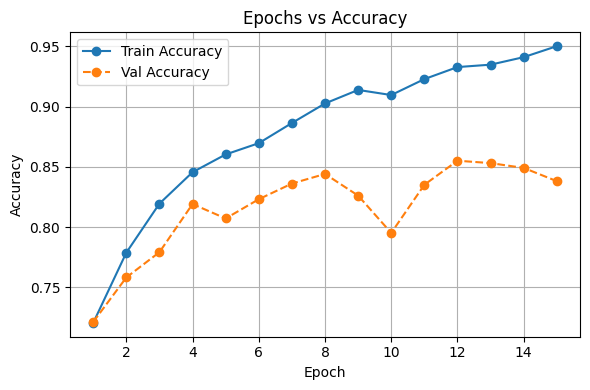

In [26]:
import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
val_acc   = history.history.get("val_accuracy", None)

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, marker="o", label="Train Accuracy")

if val_acc is not None:
    plt.plot(epochs, val_acc, marker="o", linestyle="--", label="Val Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


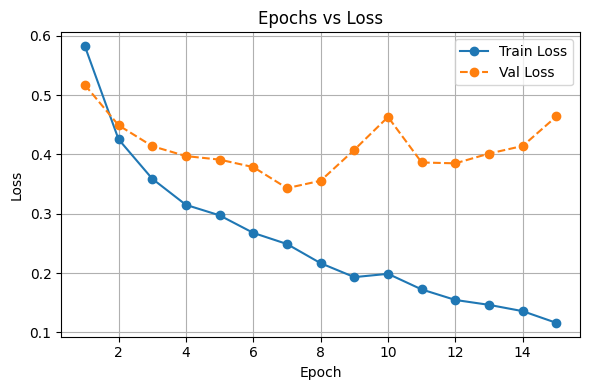

In [27]:
train_loss = history.history["loss"]
val_loss   = history.history.get("val_loss", None)

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, marker="o", label="Train Loss")

if val_loss is not None:
    plt.plot(epochs, val_loss, marker="o", linestyle="--", label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import numpy as np

# Predict probabilities on validation set
y_prob = model.predict(X_val_s)  # or X_val if you're not using _s
# Convert to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

print("y_val shape:", y_val.shape)
print("y_pred shape:", y_pred.shape)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_val shape: (1001,)
y_pred shape: (1001,)


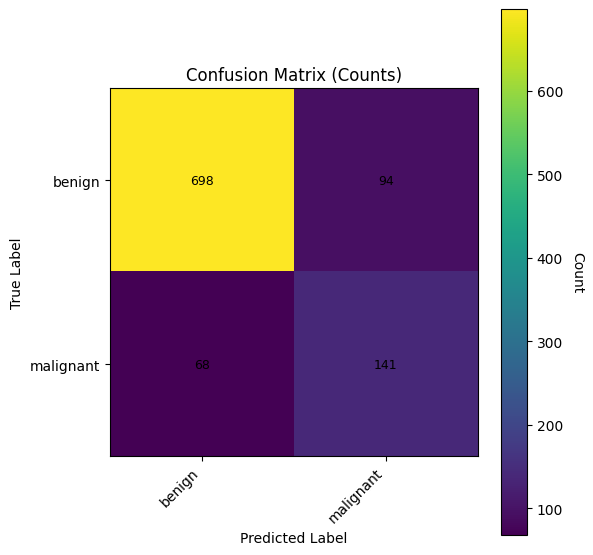

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)          # shape (n_classes, n_classes)
n_classes = cm.shape[0]

# 2. Plot
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(cm)  # default colormap; shows intensity like your example
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count", rotation=270, labelpad=15)

# 3. Tick labels
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (Counts)")

# 4. Write the numbers in each cell
for i in range(n_classes):
    for j in range(n_classes):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            fontsize=9
        )

plt.tight_layout()
plt.show()


In [30]:
# CELL 13: SAVE MODEL & SCALER ARTIFACTS

import os, json, joblib

os.makedirs("artifacts_ham10000", exist_ok=True)

model.save("artifacts_ham10000/ham_nn.keras")
joblib.dump(scaler, "artifacts_ham10000/scaler.joblib")

np.save("artifacts_ham10000/X_train_s.npy", X_train_s)
np.save("artifacts_ham10000/X_val_s.npy",   X_val_s)
np.save("artifacts_ham10000/X_test_s.npy",  X_test_s)

with open("artifacts_ham10000/class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved artifacts in ./artifacts_ham10000")


Saved artifacts in ./artifacts_ham10000
